# Pre Data Preprocessing - Task [002]

## Purpose

1. Splitting text components for better granularity.
2. Normalizing numerical values to ensure consistency.
3. Removing unnecessary symbols or irrelevant text.

The preprocessing will address these specific attributes in the dataset:
- **Style**
- **Characteristics**
- **Price**
- **Capacity**
- **ABV (Alcohol by Volume)**
- **Vintage**

In [180]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import datetime
import re

# Load the dataset
file_path = '../datasets/WineDataset.csv'
df = pd.read_csv(file_path)

def convert_to_liters(capacity):
    capacity = str(capacity).strip().upper()
    if 'CL' in capacity:  # Centiliters to Liters
        return float(re.sub(r'[^\d.]', '', capacity)) / 100
    elif 'ML' in capacity:  # Milliliters to Liters
        return float(re.sub(r'[^\d.]', '', capacity)) / 1000
    elif 'LITRE' in capacity or 'L' in capacity:  # Liters already
        return float(re.sub(r'[^\d.]', '', capacity))
    elif 'LTR' in capacity or 'L' in capacity:  # Liters already
        return float(re.sub(r'[^\d.]', '', capacity))
    elif 'L' in capacity or 'L' in capacity:  # Liters already
        return float(re.sub(r'[^\d.]', '', capacity))
    else:
        return ''  # Handle any unknown format

def preprocess_data(df):

    numeric_cols = ['Price', 'ABV', 'Capacity']

    df['Capacity'] = df['Capacity'].apply(convert_to_liters)

    if not df.empty:
        for col in numeric_cols:
            if col in df.columns:
                # Remove non-numeric characters and convert to float
                df[col] = df[col].apply(lambda x: re.sub(r'[^\d.]', '', str(x)).strip() if str(x).strip() else np.nan)
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
                if df[col].notnull().any():  # Check if there's valid data for scaling
                    scaler = MinMaxScaler()
                    df[col] = scaler.fit_transform(df[[col]])
                
                df[col] = df[col].round(3)

        # Clean and split the 'Style' column
        if 'Style' in df.columns:
            df['Style'] = (
                df['Style']
                .str.replace(r'[^\w\s&]', '', regex=True)
                .str.split('&')
                .apply(lambda x: [item.strip() for item in x] if isinstance(x, list) else x)  # Clean whitespace
            )

            # This code divides the 'Style' array into several columns, each representing a position in that array
            max_len = df['Style'].apply(lambda x: len(x) if isinstance(x, list) else 0).max()

            for i in range(1, max_len + 1):
                df[f'Style {i}'] = df['Style'].apply(lambda x: x[i-1] if isinstance(x, list) and len(x) >= i else '')

            df = df.drop(columns=['Style'])

        # Clean and split the 'Characteristics' column
        if 'Characteristics' in df.columns:
            df['Characteristics'] = (
                df['Characteristics']
                .str.replace(r'[^\w\s,]', '', regex=True)
                .str.split(',') 
                .apply(lambda x: [item.strip() for item in x] if isinstance(x, list) else x)  # Clean whitespace
            )
            
            # This code divides the 'Characteristics' array into several columns, each representing a position in that array
            max_len = df['Characteristics'].apply(lambda x: len(x) if isinstance(x, list) else 0).max()

            for i in range(1, max_len + 1):
                df[f'Characteristic {i}'] = df['Characteristics'].apply(lambda x: x[i-1] if isinstance(x, list) and len(x) >= i else '')

            df = df.drop(columns=['Characteristics'])
            
        # Clean and normalize the 'Vintage' column
        if 'Vintage' in df.columns:
            current_year = datetime.datetime.now().year

            df['Vintage'] = df['Vintage'].apply(
                lambda x: current_year if str(x).strip().upper() == 'NV' else (int(re.search(r'\d{4}', str(x)).group(0)) if re.search(r'\d{4}', str(x)) else np.nan)
            )

            valid_years = df['Vintage'][df['Vintage'] > 1900]
            if not valid_years.empty:

                min_year = valid_years.min()  
                max_year = current_year

                # Calculates the vintage value based on the max vintage and the current year
                df['Vintage'] = df['Vintage'].apply(
                    lambda x: max(0, (x - max_year) / (min_year - max_year)) if pd.notna(x) else np.nan
                )

                # Round the 'Vintage' values to 2 decimal places
                df['Vintage'] = df['Vintage'].round(2)

    return df

# Preprocess the dataset
df_cleaned = preprocess_data(df)

# Save or display the cleaned dataset
df_cleaned.to_csv('../datasets/cleaned_wines.csv', index=False)
df_cleaned.head()


,Title,Description,Price,Capacity,Grape,Secondary Grape Varieties,Closure,Country,Unit,Per bottle / case / each,...,Characteristic 1,Characteristic 2,Characteristic 3,Characteristic 4,Characteristic 5,Characteristic 6,Characteristic 7,Characteristic 8,Characteristic 9,Characteristic 10
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,0.012,0.081,Tempranillo,NaN,Natural Cork,Spain,10.5,per bottle,...,Vanilla,Blackberry,Blackcurrant,,,,,,,
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. Itâ€...,0.026,0.081,Chardonnay,NaN,Natural Cork,USA,10.1,per bottle,...,Vanilla,Almond,Coconut,Green Apple,Peach,Pineapple,Stone Fruit,,,
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,0.018,0.081,Sauvignon Blanc,NaN,Screwcap,New Zealand,9.8,per bottle,...,Tropical Fruit,Gooseberry,Grapefruit,Grass,Green Apple,Lemon,Stone Fruit,,,
3,Louis Latour MÃ¢con-Lugny 2021/22,Weâ€™ve sold this wine for thirty years â€“ an...,0.031,0.081,Chardonnay,NaN,Natural Cork,France,10.1,per bottle,...,Peach,Apricot,Floral,Lemon,,,,,,
4,Bread & Butter 'Winemaker's Selection' Pinot N...,Bread & Butter is that thing that you can coun...,0.026,0.081,Pinot Noir,NaN,Natural Cork,USA,10.1,per bottle,...,Smoke,Black Cherry,Cedar,Raspberry,Red Fruit,,,,,


# Pre Data Preprocessing - Task [92]

## Purpose

1. Merging both updated_wines.csv that has the mean ratings, with the merged_wine_dataset that was the result of Report 2(id:65). Adding the rating of the first dataset to the second.

In [181]:
import pandas as pd

file1 = "../datasets/updated_wines.csv"
file2 = "../datasets/merged_wine_dataset.csv"

df1 = pd.read_csv(file1) 
df2 = pd.read_csv(file2) 

# Merge the datasets based on WineName and WineryName
merged_df = df2.merge(df1[['WineName', 'WineryName', 'Ratings']], on=['WineName', 'WineryName'], how='left')

# Save the new dataset
output_file = "../datasets/PLNTD_dataset.csv"
merged_df.to_csv(output_file, index=False)

print(f"PLNTD_dataset created and saved to {output_file}")

missing_ratings = merged_df[merged_df['Ratings'].isna()]

#Testing purposes
if not missing_ratings.empty:
    print("WARNING: Some rows in the dataset are missing a rating.")
    print(missing_ratings)
else:
    print("SUCCESS: All rows have a rating.")


PLNTD_dataset created and saved to ../datasets/PLNTD_dataset.csv
SUCCESS: All rows have a rating.


# ELECTRE

Benefit Criteria: ['ABV', 'Ratings', 'Body']
Cost Criteria: ['Price', 'Acidity']


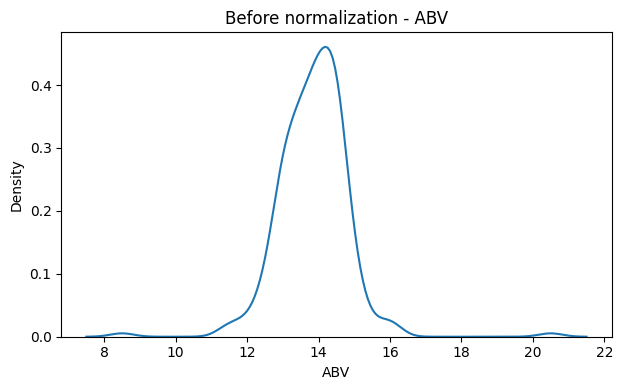

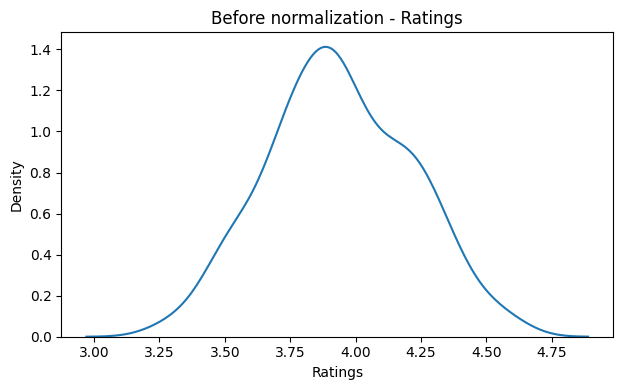

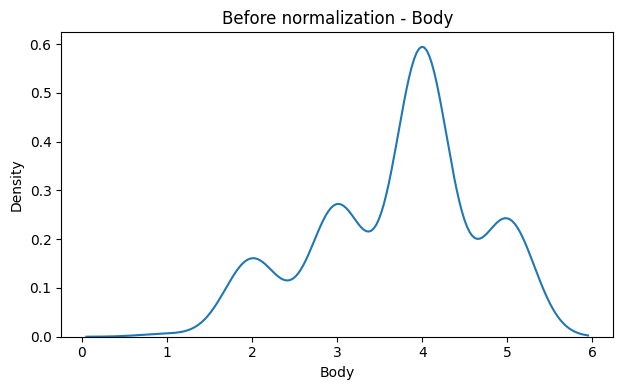

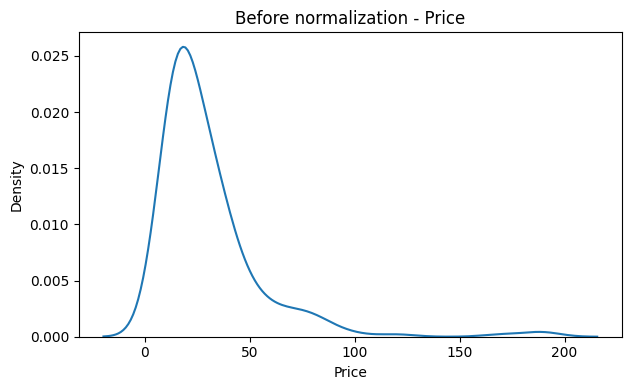

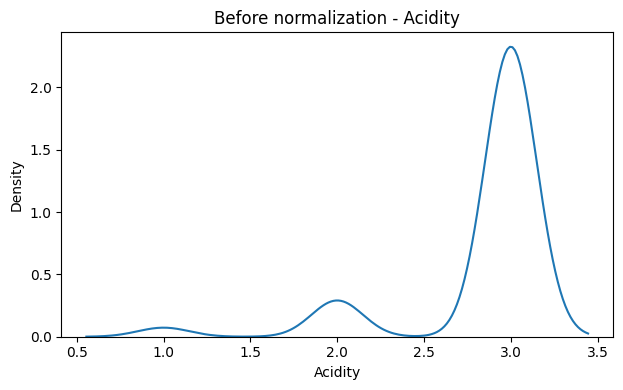

      ABV  Ratings  Body  Price  Acidity
0    13.5     3.94     4  15.99        3
1    13.5     3.96     3  15.99        3
2    14.5     4.09     4  17.99        3
3    13.5     3.96     4  15.99        3
4    13.0     3.78     2  14.99        3
..    ...      ...   ...    ...      ...
217  14.5     4.41     4  72.99        3
218  13.0     3.53     3  14.99        3
219  11.5     4.15     3  39.99        3
220  11.5     3.56     3  39.99        3
221  14.0     3.85     4   9.99        2

[222 rows x 5 columns]
Normalizing DataFrame:
          ABV   Ratings  Body     Price  Acidity
0    0.416667  0.507353  0.75  0.049451      1.0
1    0.416667  0.522059  0.50  0.049451      1.0
2    0.500000  0.617647  0.75  0.060440      1.0
3    0.416667  0.522059  0.75  0.049451      1.0
4    0.375000  0.389706  0.25  0.043956      1.0
..        ...       ...   ...       ...      ...
217  0.500000  0.852941  0.75  0.362637      1.0
218  0.375000  0.205882  0.50  0.043956      1.0
219  0.250000  0.661

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define benefit_criteria


benefit_criteria = ['ABV', 'Ratings', 'Body']
cost_criteria = ['Price', 'Acidity']
print("Benefit Criteria:", benefit_criteria)
print("Cost Criteria:", cost_criteria)

# Convert categorical 'Acidity' to numeric values (encoding)
# Convert categorical 'Acidity' and 'Body' to numeric values (encoding)
acidity_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
body_mapping = {'Very light-bodied': 1, 'Light-bodied': 2, 'Medium-bodied': 3, 'Full-bodied': 4, 'Very full-bodied': 5}

merged_df['Acidity'] = [acidity_mapping[val] for val in merged_df['Acidity']]
merged_df['Body'] = [body_mapping[val] for val in merged_df['Body']]

merged_df['ABV'] = merged_df['ABV'].str.replace('ABV ', '').str.replace('%', '').astype(float)
merged_df['Price'] = merged_df['Price'].str.replace('£', '').str.replace('per bottle', '').astype(float)

columns_to_keep = benefit_criteria + cost_criteria
merged_df = merged_df[columns_to_keep]


for column in merged_df.columns:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.kdeplot(merged_df[column])
    plt.title(f'Before normalization - {column}')
    plt.tight_layout()
    plt.show()

print(merged_df)


print("Normalizing DataFrame:")
scaler = MinMaxScaler()
normalized_df = pd.DataFrame(scaler.fit_transform(merged_df), columns=merged_df.columns)
print(normalized_df)

In [183]:
# Step 2: Calculate concordance matrix
print("Calculating Concordance Matrix...")
# Ensure weights are a numpy array
weights = [1 / normalized_df.columns.size] * normalized_df.columns.size
weights = np.array(weights)
# Get the number of alternatives
alternatives = normalized_df.index
n = len(alternatives)
# Initialize the concordance matrix
concordance_matrix = pd.DataFrame(np.zeros((n, n)), index=alternatives, columns=alternatives)
# Calculate the concordance index for each pair of alternatives
for i in range(n):
    for j in range(n):
        if i != j:
            # Identify criteria where alternative i is at least as good as alternative j
            F = normalized_df.iloc[i] >= normalized_df.iloc[j]
            # Sum the weights of these criteria
            concordance_matrix.iloc[i, j] = np.sum(weights[F]) / np.sum(weights)

Calculating Concordance Matrix...


In [184]:
# Step 3: Calculate discordance matrix
print("Calculating Discordance Matrix...")
# Calculate the range (d_k) for each criterion
ranges = normalized_df.max() - normalized_df.min()

# Initialize a dictionary to store discordance matrices for each criterion
discordance_matrices = {}

# Iterate through each criterion
for criterion in normalized_df[cost_criteria]:
    # Create an empty matrix for the discordance index of this criterion
    num_alternatives = len(normalized_df)
    discordance_matrix = np.zeros((num_alternatives, num_alternatives))

    # Calculate pairwise discordance for all alternatives
    for i in range(num_alternatives):
        for j in range(num_alternatives):
            if i != j:
                difference = normalized_df.loc[j, criterion] - normalized_df.loc[i, criterion]
                if difference > 0:
                    discordance_matrix[i, j] = difference / ranges[criterion]

    # Store the discordance matrix for this criterion
    discordance_matrices[criterion] = discordance_matrix

Calculating Discordance Matrix...


In [185]:
# Step 4: Generate dominance matrix
print("Generating Dominance Matrix...")
c_threshold = 0.6  # Example threshold for concordance
d_threshold = 0.4  # Example threshold for discordance
print(f"Concordance Threshold: {c_threshold}, Discordance Threshold: {d_threshold}")

# Ensure the matrices are numpy arrays
concordance_matrix = np.array(concordance_matrix)
discordance_matrix = np.array(discordance_matrix)
# Get the number of alternatives
n = concordance_matrix.shape[0]
# Initialize the dominance matrix with zeros
dominance_matrix = np.zeros((n, n), dtype=int)
# Iterate over all pairs of alternatives
for i in range(n):
    for j in range(n):
        if i != j:  # Exclude self-comparison
            if (concordance_matrix[i, j] >= c_threshold and
                    discordance_matrix[i, j] <= d_threshold):
                dominance_matrix[i, j] = 1

Generating Dominance Matrix...
Concordance Threshold: 0.6, Discordance Threshold: 0.4


In [186]:
dominance_scores = dominance_matrix.sum(axis=1)
print("Dominance Scores:")
print(dominance_scores)

ranked_alternatives = np.argsort(-dominance_scores)  # Descending order
print("Ranked Alternatives (Best to Worst):")
print(ranked_alternatives)

Dominance Scores:
[142 122 199 147  64 180 191  22  83 113 204 198  64 195 172 121 194 197
 188 161 157   4 178  91  60 172 172 178 148 112 169   6  20 207 209 138
   3 105 113  26 166 197  13 169  20  36 170 203 186 202 200 186  18 111
 148 111  27 208  36  16 141 125 202  36  77 165 118   5 129 101 122 140
 221 212 212 218 216 209 187 207 220 103 212   4 167  27  77 174 169 187
 178 132 180  29 200  87 221 221 206  23 117  27  32 214 157  52 205  78
 218 105 215 214  68 211 176 172  26 216 205 196   4  84 195 123 218 220
 118  97  36 180 187  59 155  18  75 104 148 166  74 199 211 157 181 193
 130   4 207  97 216 127 200   4 145  29 170  28 211  14 127 171 130 180
 176 214 142  26  99 217 194 196 203 215 123  18  27  48  25  13 214 197
  98 209 215 201 151  82 140 142  80 205  76 211 211  85  94  97 104 180
 205 117 181 200 150  88  79  77  92 212  26 122 165 182 191  70 218 219
 209 216  52 166  78  22]
Ranked Alternatives (Best to Worst):
[ 96  97  72 125  80 215 124 108 214  75 16

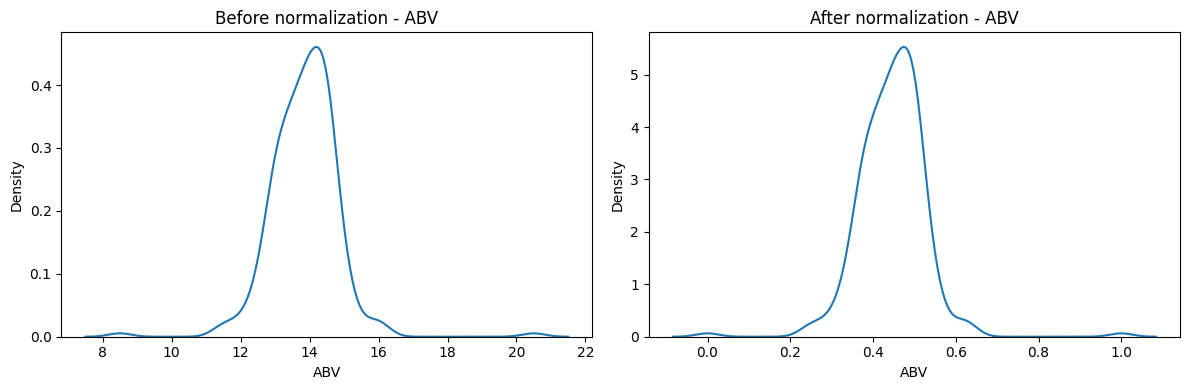

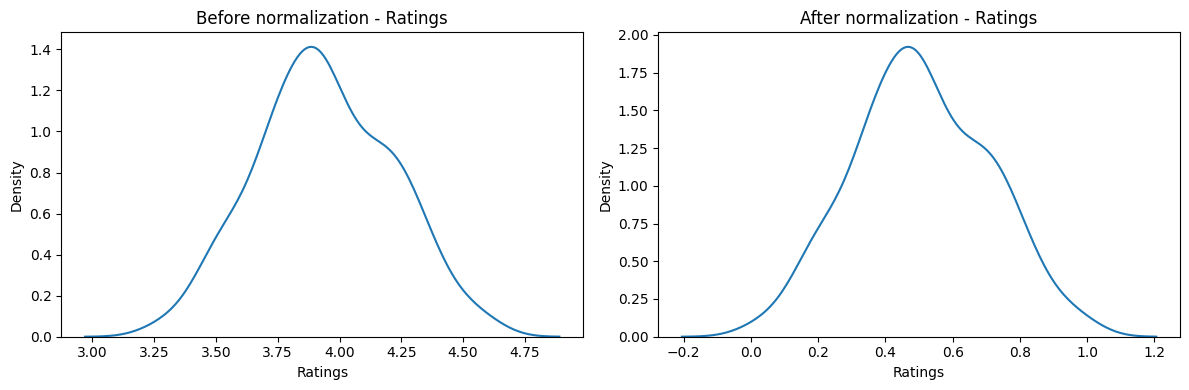

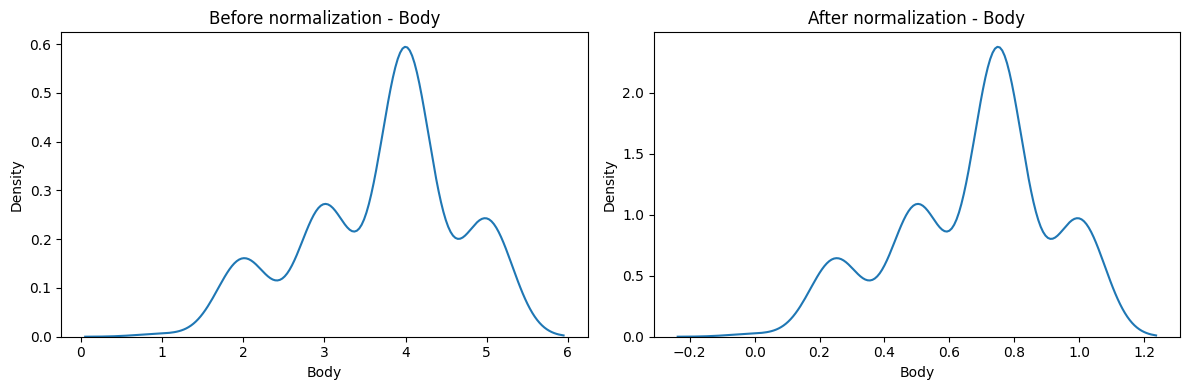

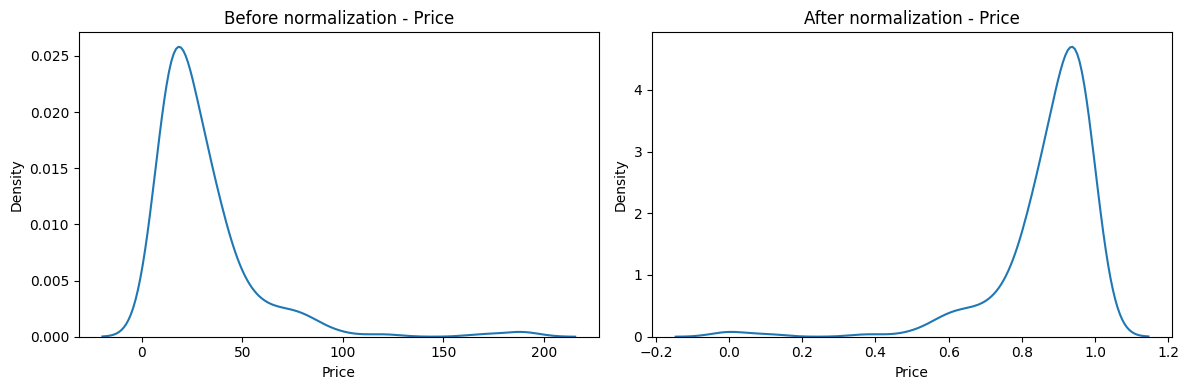

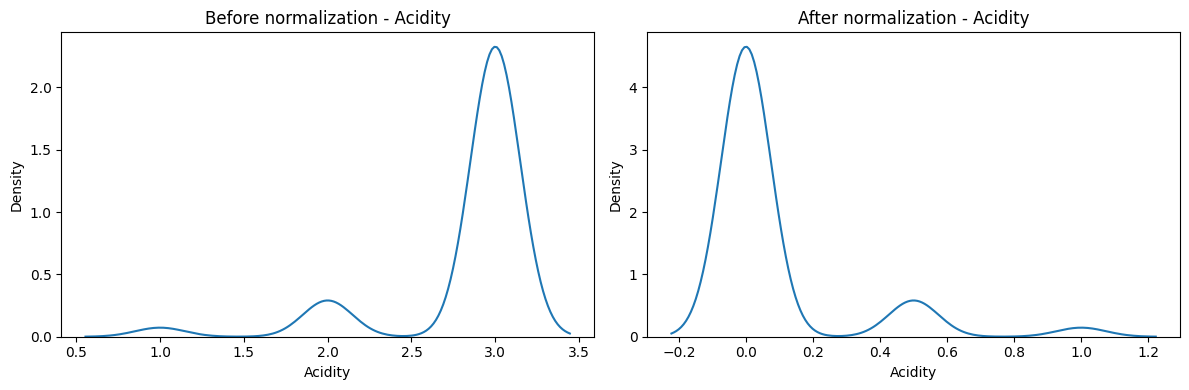


Final Rankings:
67      220
75      164
77      153
76      143
56      142
       ... 
194    -147
175    -147
195    -152
193    -154
220    -165
Length: 222, dtype: object


In [187]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

# Your initial data preparation
benefit_criteria = ['ABV', 'Ratings', 'Body']
cost_criteria = ['Price', 'Acidity']
all_criteria = benefit_criteria + cost_criteria

# Create direction dictionary (1 for benefit/maximization, 0 for cost/minimization)
direction = {}
for criterion in benefit_criteria:
    direction[criterion] = 1
for criterion in cost_criteria:
    direction[criterion] = 0

# Copy the dataframe for normalization
n_table = merged_df.copy()

# Using normalization rule 2 (adapted from the original code)
denom = dict(merged_df.apply(lambda x: x.max() - x.min()))
_min = dict(merged_df.apply(lambda x: x.min()))
_max = dict(merged_df.apply(lambda x: x.max()))

# Normalize each column based on whether it's a benefit or cost criterion
for column in merged_df.columns:
    if direction[column]:  # benefit criteria (maximize)
        n_table[column] = merged_df[column].apply(lambda x: (x - _min[column]) / denom[column])
    else:  # cost criteria (minimize)
        n_table[column] = merged_df[column].apply(lambda x: (_max[column] - x) / denom[column])

# Visualization of before and after normalization
for column in merged_df.columns:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.kdeplot(merged_df[column])
    plt.title(f'Before normalization - {column}')
    plt.subplot(1, 2, 2)
    sns.kdeplot(n_table[column])
    plt.title(f'After normalization - {column}')
    plt.tight_layout()
    plt.show()

# Define weights (equal weights for simplicity, can be modified)
weights = {criterion: 1/len(all_criteria) for criterion in all_criteria}

# Calculate concordance matrix
c_matrix = pd.DataFrame(columns=n_table.index, index=n_table.index)

for option in n_table.index:
    for option2 in n_table.index:
        _sum = 0
        for criterion in n_table.columns:
            if n_table.loc[option, criterion] > n_table.loc[option2, criterion]:
                _sum += weights[criterion]
            elif np.isclose(n_table.loc[option, criterion], n_table.loc[option2, criterion]):
                _sum += 0.5 * weights[criterion]
        if option == option2:
            c_matrix.loc[option, option2] = 0
        else:
            c_matrix.loc[option, option2] = _sum

# Calculate discordance matrix
d_matrix = pd.DataFrame(columns=n_table.index, index=n_table.index)

for option in n_table.index:
    for option2 in n_table.index:
        diffs = list(n_table.loc[option, :] - n_table.loc[option2, :])
        if not any(diffs):
            _discordance_index = 0
        else:
            n_diffs = [x for x in diffs if x < 0]
            if not n_diffs:
                num = 0
            else:
                num = max(np.abs(n_diffs))
            denom = max(np.abs(diffs))
            _discordance_index = num / denom
        d_matrix.loc[option, option2] = _discordance_index

# Calculate aggregated dominance matrix
a_matrix = pd.DataFrame(columns=c_matrix.columns, index=c_matrix.index)

# Define thresholds (can be modified)
concordance_threshold = 0.7
discordance_threshold = 0.3

for option in c_matrix.columns:
    for option2 in c_matrix.index:
        a_matrix.loc[option, option2] = 1 if (c_matrix.loc[option, option2] >= concordance_threshold and 
                                            d_matrix.loc[option, option2] <= discordance_threshold) else 0

# Calculate net dominance scores
dominance_scores = a_matrix.sum(axis=1) - a_matrix.sum(axis=0)
rankings = dominance_scores.sort_values(ascending=False)

print("\nFinal Rankings:")
print(rankings)